<a href="https://colab.research.google.com/github/rmahesh6386/Tata-Motors-Project-/blob/main/TATA_Motors_Stock_market_Forecasting_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [5]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-30,214.103531,220.435608,213.064667,219.347275,216.849060,9094027
2012-07-31,219.644104,224.591034,214.845566,223.848999,221.299500,11297966
2012-08-01,222.167038,227.262390,220.831360,224.937317,222.375412,10425962
2012-08-02,223.700592,224.591034,219.248337,220.336670,217.827179,5808700
2012-08-03,218.654709,219.644104,213.856171,218.605240,216.115463,7327872


In [7]:
df.index

DatetimeIndex(['2012-07-30', '2012-07-31', '2012-08-01', '2012-08-02',
               '2012-08-03', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Check whether you have duplicate data on by date

In [8]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


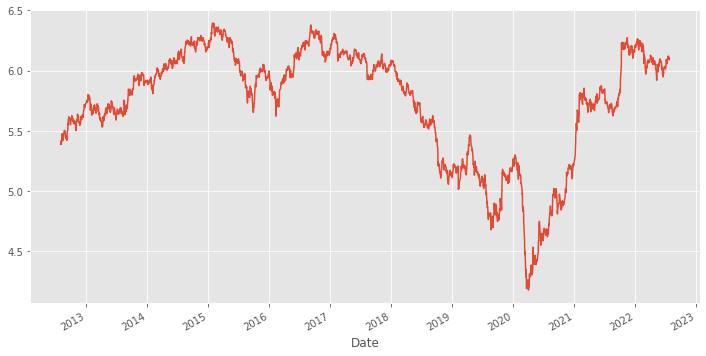

In [9]:
y = np.log(df["Close"])
y.plot()

In [10]:
y.index

DatetimeIndex(['2012-07-30', '2012-07-31', '2012-08-01', '2012-08-02',
               '2012-08-03', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10',
               ...
               '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19',
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Calculate rolling mean, exponentially weighted mean

In [11]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-21,6.119968,6.052305,6.060416
2022-07-22,6.120078,6.052198,6.061597
2022-07-25,6.108247,6.052099,6.062521
2022-07-26,6.089385,6.051954,6.063053
2022-07-27,6.095937,6.052111,6.063704


In [12]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18585515077752623
rmse over ewma:  0.1579638377676297


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

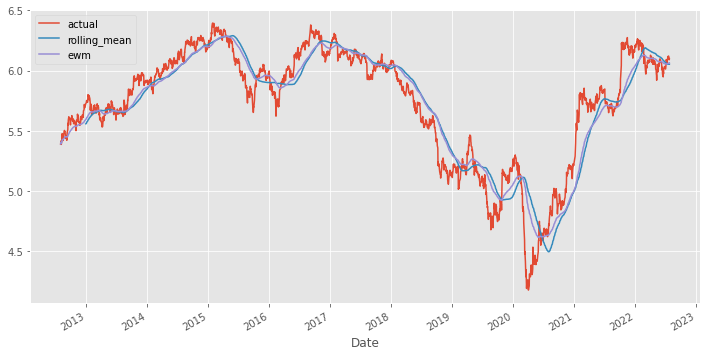

In [13]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -1.388606
p-value: 0.587726
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [15]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-07-30,5.390656,NaN,NaN
2012-07-31,5.410972,NaN,NaN
2012-08-01,5.415822,NaN,NaN
2012-08-02,5.395157,0.004500,NaN
2012-08-03,5.387268,-0.023704,-0.028205
2012-08-06,5.423271,0.007450,0.031154
2012-08-07,5.464957,0.069801,0.062351
2012-08-08,5.476201,0.088933,0.019132
2012-08-09,5.467049,0.043778,-0.045155


In [16]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.diff(periods=1).dropna())

ADF Statistic: -48.582269
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


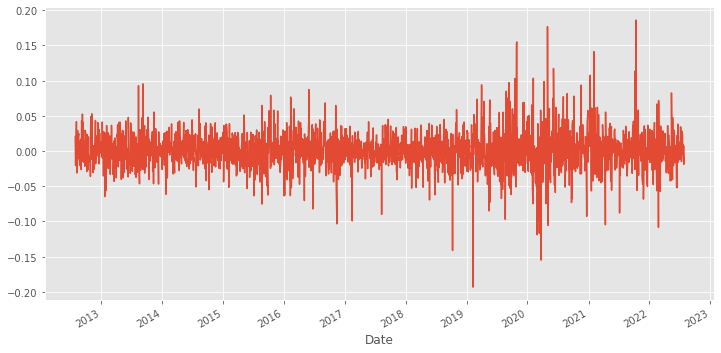

In [17]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

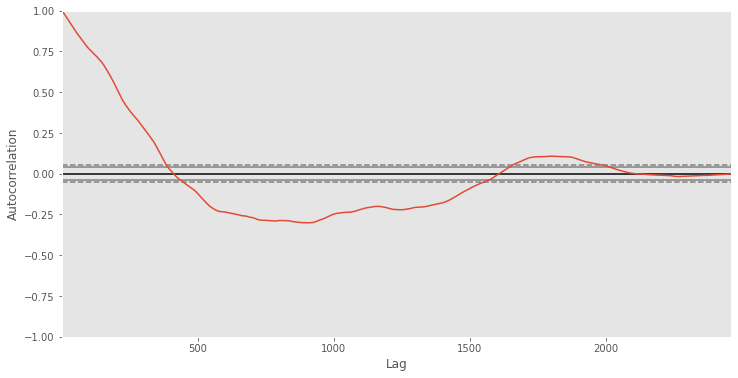

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [19]:
y = y.dropna()

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10824.432, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10823.476, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10823.458, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10826.151, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10821.751, Time=1.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.574 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5414.076
Date:                Thu, 28 Jul 2022   AIC                         -10826.151
Time:                        03:19:38   BIC                         -10820.343
Sample:                             0   HQIC                        -10824.041
                               - 2463                             

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  2.462000e+03
mean   5.689838e-10
std    2.684037e-02
min   -1.936616e-01
25%   -1.359315e-02
50%   -2.864661e-04
75%    1.318584e-02
max    1.857508e-01


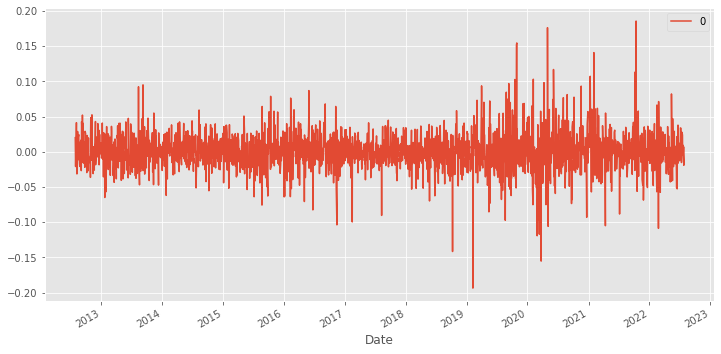

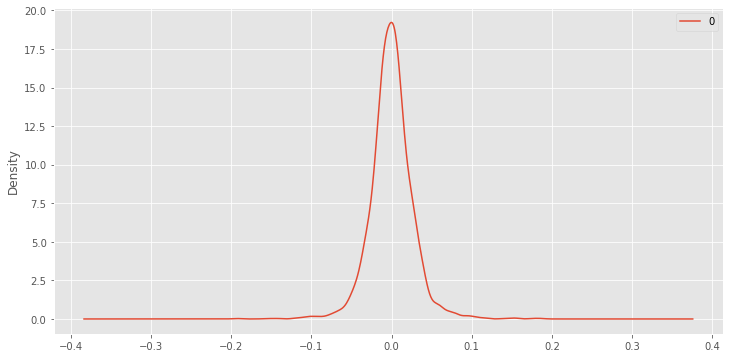

In [21]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=0

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [22]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2462
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5414.216
Method:                           css   S.D. of innovations              0.027
Date:                Thu, 28 Jul 2022   AIC                         -10824.432
Time:                        03:19:39   BIC                         -10812.815
Sample:                             1   HQIC                        -10820.211
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.530      0.596      -0.001       0.001
==============================================================================
"""

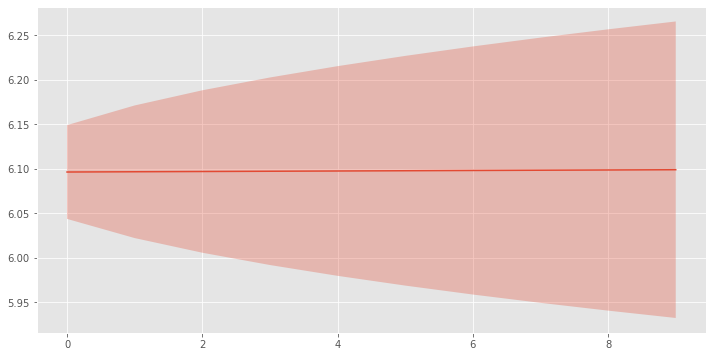

In [23]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(10)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [24]:
predictions[:10]

array([6.09622361, 6.09651007, 6.09679654, 6.09708301, 6.09736947,
       6.09765594, 6.0979424 , 6.09822887, 6.09851534, 6.0988018 ])

In [25]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

predicted=4.872604, actual=4.818263
predicted=4.817931, actual=4.808111
predicted=4.807773, actual=4.765587
predicted=4.765225, actual=4.820685
predicted=4.820355, actual=4.804431
predicted=4.804092, actual=4.803611
predicted=4.803272, actual=4.794964
predicted=4.794619, actual=4.798679
predicted=4.798337, actual=4.794136
predicted=4.793792, actual=4.819071
predicted=4.818741, actual=4.722064
predicted=4.721678, actual=4.679350
predicted=4.678940, actual=4.709981
predicted=4.709588, actual=4.705468
predicted=4.705073, actual=4.790404
predicted=4.790059, actual=4.756603
predicted=4.756238, actual=4.738827
predicted=4.738452, actual=4.759607
predicted=4.759244, actual=4.724286
predicted=4.723903, actual=4.695925
predicted=4.695526, actual=4.771108
predicted=4.770753, actual=4.797855
predicted=4.797515, actual=4.803201
predicted=4.802865, actual=4.900448
predicted=4.900168, actual=4.851640
predicted=4.851331, actual=4.864067
predicted=4.863766, actual=4.856707
predicted=4.856402, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.130049, actual=5.147494
predicted=5.147358, actual=5.139322
predicted=5.139181, actual=5.118293
predicted=5.118141, actual=5.127232
predicted=5.127085, actual=5.136387
predicted=5.136245, actual=5.122475
predicted=5.122325, actual=5.120386
predicted=5.120235, actual=5.100781
predicted=5.100619, actual=5.089755
predicted=5.089587, actual=5.112590
predicted=5.112435, actual=5.096201
predicted=5.096037, actual=5.111385
predicted=5.111230, actual=5.104733
predicted=5.104574, actual=5.084505
predicted=5.084335, actual=5.081715
predicted=5.081543, actual=5.063860
predicted=5.063679, actual=5.132263
predicted=5.132119, actual=5.112590
predicted=5.112436, actual=5.084505
predicted=5.084336, actual=5.078294
predicted=5.078121, actual=5.073297
predicted=5.073121, actual=5.086361
predicted=5.086193, actual=5.155313
predicted=5.155183, actual=5.174453
predicted=5.174334, actual=5.164500
predicted=5.164375, actual=5.194067
predicted=5.193959, actual=5.163642
predicted=5.163517, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.156627, actual=5.129307
predicted=5.129166, actual=5.134327
predicted=5.134188, actual=5.141371
predicted=5.141236, actual=5.132853
predicted=5.132714, actual=5.130490
predicted=5.130350, actual=5.130490
predicted=5.130350, actual=5.085124
predicted=5.084960, actual=5.062911
predicted=5.062735, actual=5.065755
predicted=5.065580, actual=5.014959
predicted=5.014757, actual=5.009968
predicted=5.009764, actual=4.973625
predicted=4.973401, actual=4.978456
predicted=4.978235, actual=4.859425
predicted=4.859140, actual=4.831509
predicted=4.831209, actual=4.870223
predicted=4.869944, actual=4.837868
predicted=4.837572, actual=4.834296
predicted=4.833998, actual=4.737951
predicted=4.737602, actual=4.660605
predicted=4.660214, actual=4.594109
predicted=4.593683, actual=4.477337
predicted=4.476849, actual=4.497028
predicted=4.496551, actual=4.418238
predicted=4.417719, actual=4.356068
predicted=4.355515, actual=4.324133
predicted=4.323564, actual=4.289774
predicted=4.289187, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.434475, actual=4.390119
predicted=4.389596, actual=4.404277
predicted=4.403762, actual=4.424248
predicted=4.423743, actual=4.432007
predicted=4.431506, actual=4.416428
predicted=4.415920, actual=4.420045
predicted=4.419539, actual=4.437343
predicted=4.436846, actual=4.465908
predicted=4.465426, actual=4.465908
predicted=4.465427, actual=4.494797
predicted=4.494331, actual=4.569543
predicted=4.569116, actual=4.592591
predicted=4.592177, actual=4.590057
predicted=4.589641, actual=4.707275
predicted=4.706921, actual=4.748838
predicted=4.748504, actual=4.713576
predicted=4.713225, actual=4.713127
predicted=4.712776, actual=4.664853
predicted=4.664477, actual=4.656813
predicted=4.656433, actual=4.610158
predicted=4.609754, actual=4.551242
predicted=4.550808, actual=4.558079
predicted=4.557648, actual=4.567987
predicted=4.567562, actual=4.629863
predicted=4.629470, actual=4.631325
predicted=4.630933, actual=4.648230
predicted=4.647847, actual=4.652054
predicted=4.651673, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.816356, actual=4.833102
predicted=4.832820, actual=4.829513
predicted=4.829229, actual=4.801559
predicted=4.801261, actual=4.794964
predicted=4.794663, actual=4.797442
predicted=4.797143, actual=4.844974
predicted=4.844699, actual=4.926529
predicted=4.926295, actual=4.971548
predicted=4.971337, actual=4.961445
predicted=4.961229, actual=4.964242
predicted=4.964028, actual=4.968423
predicted=4.968211, actual=5.012633
predicted=5.012443, actual=5.022893
predicted=5.022708, actual=4.995860
predicted=4.995662, actual=5.006627
predicted=5.006434, actual=4.957938
predicted=4.957720, actual=4.942356
predicted=4.942132, actual=4.964940
predicted=4.964727, actual=4.971894
predicted=4.971685, actual=5.000922
predicted=5.000726, actual=4.999911
predicted=4.999716, actual=5.020256
predicted=5.020070, actual=4.994845
predicted=4.994647, actual=4.996536
predicted=4.996339, actual=4.923260
predicted=4.923027, actual=4.891101
predicted=4.890851, actual=4.878246
predicted=4.877990, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.016765, actual=5.018603
predicted=5.018421, actual=4.986001
predicted=4.985803, actual=5.002939
predicted=5.002749, actual=5.062595
predicted=5.062434, actual=5.156178
predicted=5.156063, actual=5.123666
predicted=5.123536, actual=5.130490
predicted=5.130363, actual=5.139908
predicted=5.139785, actual=5.147785
predicted=5.147667, actual=5.144292
predicted=5.144171, actual=5.157617
predicted=5.157504, actual=5.194899
predicted=5.194804, actual=5.191567
predicted=5.191470, actual=5.212760
predicted=5.212673, actual=5.219545
predicted=5.219461, actual=5.215751
predicted=5.215665, actual=5.212487
predicted=5.212400, actual=5.202907
predicted=5.202816, actual=5.207845
predicted=5.207757, actual=5.179534
predicted=5.179431, actual=5.186547
predicted=5.186448, actual=5.179815
predicted=5.179713, actual=5.186827
predicted=5.186728, actual=5.207024
predicted=5.206935, actual=5.202357
predicted=5.202266, actual=5.196008
predicted=5.195913, actual=5.103214
predicted=5.103075, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.723088, actual=5.726848
predicted=5.727006, actual=5.733179
predicted=5.733341, actual=5.713898
predicted=5.714050, actual=5.728150
predicted=5.728308, actual=5.685109
predicted=5.685248, actual=5.654417
predicted=5.654541, actual=5.691710
predicted=5.691851, actual=5.693900
predicted=5.694043, actual=5.709765
predicted=5.709914, actual=5.729288
predicted=5.729446, actual=5.720476
predicted=5.720630, actual=5.729288
predicted=5.729446, actual=5.729450
predicted=5.729609, actual=5.749234
predicted=5.749401, actual=5.762680
predicted=5.762854, actual=5.657913
predicted=5.658038, actual=5.713238
predicted=5.713388, actual=5.715382
predicted=5.715533, actual=5.736572
predicted=5.736734, actual=5.708438
predicted=5.708586, actual=5.697261
predicted=5.697404, actual=5.685449
predicted=5.685586, actual=5.683580
predicted=5.683716, actual=5.688330
predicted=5.688469, actual=5.708770
predicted=5.708918, actual=5.723258
predicted=5.723413, actual=5.710096
predicted=5.710244, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.746687, actual=5.742522
predicted=5.742685, actual=5.753366
predicted=5.753533, actual=5.754159
predicted=5.754326, actual=5.763936
predicted=5.764108, actual=5.764407
predicted=5.764579, actual=5.764407
predicted=5.764579, actual=5.762366
predicted=5.762537, actual=5.777652
predicted=5.777830, actual=5.785823
predicted=5.786005, actual=5.813981
predicted=5.814176, actual=5.844993
predicted=5.845201, actual=5.865760
predicted=5.865978, actual=5.838750
predicted=5.838956, actual=5.842820
predicted=5.843027, actual=5.860074
predicted=5.860289, actual=5.874790
predicted=5.875012, actual=5.865618
predicted=5.865835, actual=5.856074
predicted=5.856287, actual=5.845427
predicted=5.845635, actual=5.821269
predicted=5.821466, actual=5.812039
predicted=5.812231, actual=5.822750
predicted=5.822947, actual=5.814877
predicted=5.815070, actual=5.813085
predicted=5.813278, actual=5.827916
predicted=5.828115, actual=5.837147
predicted=5.837351, actual=5.833494
predicted=5.833696, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.645915, actual=5.623837
predicted=5.623942, actual=5.634075
predicted=5.634184, actual=5.650382
predicted=5.650498, actual=5.650030
predicted=5.650146, actual=5.655117
predicted=5.655236, actual=5.676583
predicted=5.676711, actual=5.660527
predicted=5.660648, actual=5.687822
predicted=5.687955, actual=5.680684
predicted=5.680814, actual=5.688838
predicted=5.688971, actual=5.695246
predicted=5.695382, actual=5.685619
predicted=5.685750, actual=5.687822
predicted=5.687955, actual=5.700276
predicted=5.700414, actual=5.707775
predicted=5.707916, actual=5.723912
predicted=5.724060, actual=5.742843
predicted=5.743000, actual=5.741881
predicted=5.742037, actual=5.732046
predicted=5.732198, actual=5.700276
predicted=5.700414, actual=5.710261
predicted=5.710404, actual=5.736895
predicted=5.737049, actual=5.772998
predicted=5.773167, actual=5.761894
predicted=5.762059, actual=5.804080
predicted=5.804264, actual=5.796969
predicted=5.797149, actual=5.799850
predicted=5.800031, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.209543, actual=6.249493
predicted=6.249860, actual=6.223171
predicted=6.223527, actual=6.227327
predicted=6.227684, actual=6.223568
predicted=6.223923, actual=6.215807
predicted=6.216159, actual=6.203749
predicted=6.204096, actual=6.200002
predicted=6.200347, actual=6.217105
predicted=6.217457, actual=6.229398
predicted=6.229755, actual=6.212305
predicted=6.212655, actual=6.155813
predicted=6.156139, actual=6.222576
predicted=6.222930, actual=6.211503
predicted=6.211852, actual=6.214508
predicted=6.214858, actual=6.200813
predicted=6.201158, actual=6.203446
predicted=6.203791, actual=6.170134
predicted=6.170464, actual=6.167516
predicted=6.167846, actual=6.059006
predicted=6.059290, actual=6.130683
predicted=6.130997, actual=6.118207
predicted=6.118516, actual=6.103900
predicted=6.104202, actual=6.080162
predicted=6.080454, actual=6.033686
predicted=6.033958, actual=5.976351
predicted=5.976599, actual=5.970624
predicted=5.970869, actual=6.006107
predicted=6.006367, actual=6

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.127287, actual=6.122822
predicted=6.123129, actual=6.108136
predicted=6.108437, actual=6.113793
predicted=6.114096, actual=6.113793
predicted=6.114096, actual=6.082904
predicted=6.083193, actual=6.066224
predicted=6.066507, actual=6.072584
predicted=6.072869, actual=6.051972
predicted=6.052248, actual=6.088024
predicted=6.088315, actual=6.104905
predicted=6.105203, actual=6.084158
predicted=6.084447, actual=6.052442
predicted=6.052718, actual=6.075116
predicted=6.075402, actual=6.064366
predicted=6.064647, actual=6.077757
predicted=6.078043, actual=6.081305
predicted=6.081593, actual=6.070391
predicted=6.070674, actual=6.048554
predicted=6.048827, actual=6.055143
predicted=6.055420, actual=6.012614
predicted=6.012873, actual=6.001291
predicted=6.001545, actual=5.970624


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.970865, actual=5.961392
predicted=5.961629, actual=5.919700
predicted=5.919920, actual=6.002157
predicted=6.002411, actual=6.004751
predicted=6.005006, actual=6.050087
predicted=6.050361, actual=6.028640
predicted=6.028904, actual=5.988084
predicted=5.988331, actual=6.035481
predicted=6.035749, actual=6.043701
predicted=6.043972, actual=6.053852
predicted=6.054127, actual=6.033086
predicted=6.033352, actual=6.041801
predicted=6.042070, actual=6.062855
predicted=6.063132, actual=6.092214
predicted=6.092504, actual=6.094811
predicted=6.095101, actual=6.097175
predicted=6.097467, actual=6.084841
predicted=6.085128, actual=6.068194
predicted=6.068474, actual=6.069235
predicted=6.069515, actual=6.077298
predicted=6.077581, actual=6.076839
predicted=6.077122, actual=6.060291
predicted=6.060567, actual=6.059240
predicted=6.059515, actual=6.008076
predicted=6.008330, actual=6.004257
predicted=6.004510, actual=6.026108
predicted=6.026369, actual=5.973682
predicted=5.973922, actual=5

In [26]:
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 0.034


In [27]:
result = pd.DataFrame(np.exp(y))[train_size:]
result.columns = ["actual"]
result["prediction"] = np.exp(predictions)
result

,actual,prediction
Date,,
2019-08-05,123.750000,130.660728
2019-08-06,122.500000,123.708920
2019-08-07,117.400002,122.458638
2019-08-08,124.050003,117.357493
2019-08-09,122.050003,124.009069
...,...,...
2022-07-21,454.850006,453.584061
2022-07-22,454.899994,454.984984
2022-07-25,449.549988,455.034952


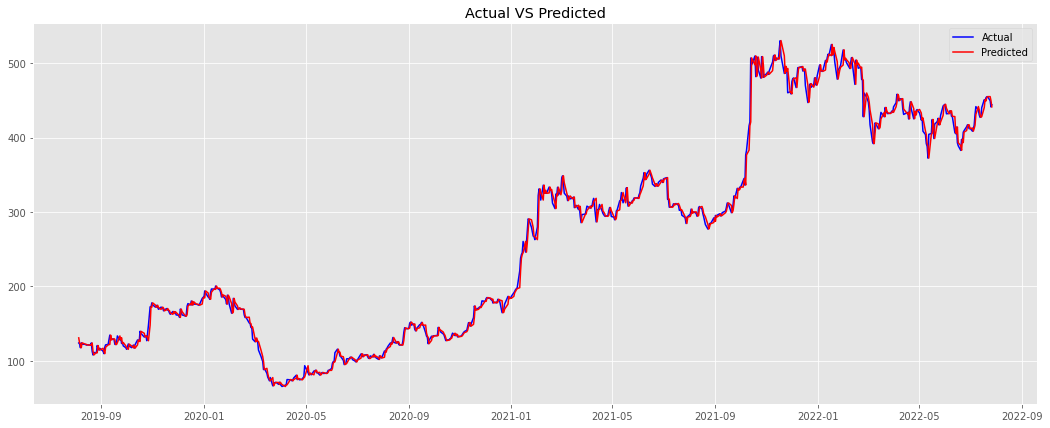

In [28]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(result["actual"],color='blue',label='Actual')
plt.plot(result["prediction"], color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [29]:
model = ARIMA(y, order=(0,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [34]:
predictions=pd.Series(model_fit.fittedvalues, copy=True)
print(predictions.head())

Date
2012-07-31    0.000286
2012-08-01    0.000286
2012-08-02    0.000286
2012-08-03    0.000286
2012-08-06    0.000286
dtype: float64


In [35]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2012-07-31    0.000286
2012-08-01    0.000573
2012-08-02    0.000859
2012-08-03    0.001146
2012-08-06    0.001432
dtype: float64


In [39]:
predictions_log=pd.Series(y, index=y.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

Date
2012-07-30    5.390656
2012-07-31    5.411258
2012-08-01    5.416395
2012-08-02    5.396016
2012-08-03    5.388413
dtype: float64

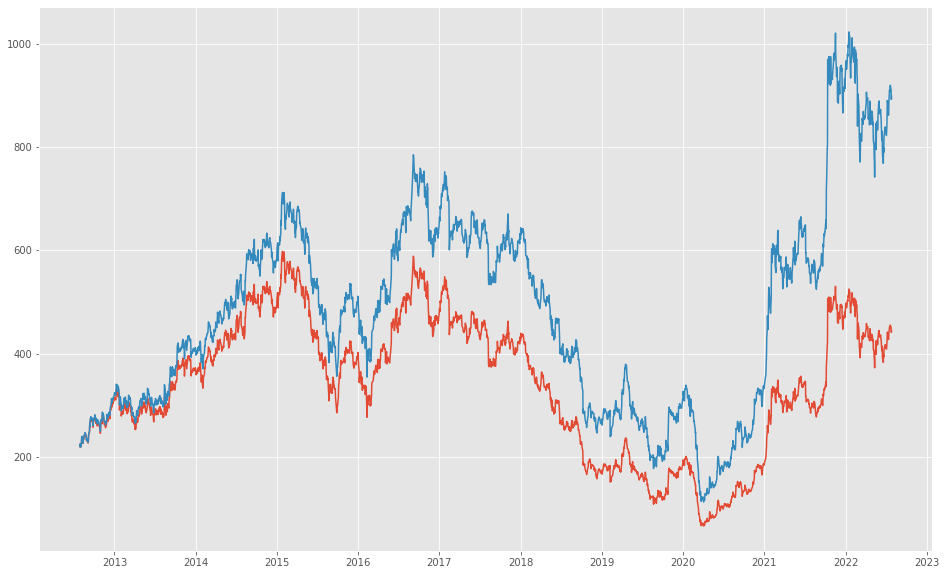

In [41]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(16,10))
plt.plot(df["Close"])
plt.plot(predictions_ARIMA)

In [42]:
forecast=model_fit.forecast(steps=10)[0]
np.exp(forecast)

array([444.17721128, 444.30447122, 444.43176762, 444.5591005 ,
       444.68646985, 444.8138757 , 444.94131805, 445.06879691,
       445.19631229, 445.32386421])